# Multi-Omics Analysis for LUSC Survival Prediction

Bla



## Imports and helper functions

In [1]:
import os
import shutil
import io
import glob
import requests
import json
import tarfile
import random
import warnings
import itertools
import functools
import re
import signal
import contextlib

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import lifelines
from tqdm.notebook import tqdm, trange

import sklearn
from sklearn.preprocessing import scale, minmax_scale, robust_scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif

from pypgatk.cgenomes.cbioportal_downloader import CbioPortalDownloadService

In [2]:
# Set the random seeds
seed = 0
torch.random.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
dim_reduction = TSNE
dim_reduction_label = "TSNE_{}"

### Helper Functions

In [4]:
class TimeoutException(Exception): pass

@contextlib.contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

### Data acquisition and reading

In [5]:
def download_maui_data(
        output_directory = "./data/maui_data",
        **kwargs
        ):
    
    os.makedirs(output_directory, exist_ok=True)

    if not os.path.isfile(os.path.join(output_directory, 'cnv.csv')):
        urllib.request.urlretrieve(
            url='http://bimsbstatic.mdc-berlin.de/akalin/maui-data/coread_for_paper_cnv.csv',
            filename=os.path.join(output_directory, 'cnv.csv')
        )

    if not os.path.isfile(os.path.join(output_directory, 'gex.csv')):
        urllib.request.urlretrieve(
            url='http://bimsbstatic.mdc-berlin.de/akalin/maui-data/coread_for_paper_gex.csv',
            filename=os.path.join(output_directory, 'gex.csv')
        )

    if not os.path.isfile(os.path.join(output_directory, 'mut.csv')):
        urllib.request.urlretrieve(
            url='http://bimsbstatic.mdc-berlin.de/akalin/maui-data/coread_for_paper_mut.csv',
            filename=os.path.join(output_directory, 'mut.csv')
        )

    if not os.path.isfile(os.path.join(output_directory, 'subtypes.csv')):
        urllib.request.urlretrieve(
            url='http://bimsbstatic.mdc-berlin.de/akalin/maui-data/coread_for_paper_subtypes.csv',
            filename=os.path.join(output_directory, 'subtypes.csv')
        )

    if not os.path.isfile(os.path.join(output_directory, 'survival.csv')):
        urllib.request.urlretrieve(
            url='http://bimsbstatic.mdc-berlin.de/akalin/maui-data/coread_for_paper_survival.csv',
            filename=os.path.join(output_directory, 'survival.csv')
        )

In [6]:
def get_mirna_files(
        project_id="TCGA-LUSC",
        maxfiles=10000,
        cases_endpt = "https://api.gdc.cancer.gov/files",
        data_endpt = "https://api.gdc.cancer.gov/data"
        ):


    # Retrieve associated file names
    filters = {
        "op": "and",
        "content":[
            {"op": "=",
            "content":{
                "field": "cases.project.project_id",
                "value": ["TCGA-LUSC"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.experimental_strategy",
                "value": ["miRNA-Seq"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.data_category",
                "value": ["Transcriptome Profiling"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.data_type",
                "value": ["miRNA Expression Quantification"]
                }
            }
        ]
    }

    params = {
        "filters": json.dumps(filters),
        "fields": ",".join(["cases.samples.submitter_id","file_name", "Entity ID"]),
        "format": "TSV",
        "size": str(maxfiles)
    }

    response = requests.get(cases_endpt, params = params)
    files_df = pd.read_csv(io.StringIO(response.text), sep="\t")
    return files_df

def download_mirna_files(
        files_df,
        output_directory = "./data",
        project_id="TCGA-LUSC",
        maxfiles=10000,
        cases_endpt = "https://api.gdc.cancer.gov/files",
        data_endpt = "https://api.gdc.cancer.gov/data"
        ):
    
    params = {"ids": files_df["id"].tolist()}

    response = requests.post(data_endpt,
                            data = json.dumps(params),
                            headers={
                                "Content-Type": "application/json"
                                })

    response_head_cd = response.headers["Content-Disposition"]
    file_name = re.findall("filename=(.+)", response_head_cd)[0]
    with open(os.path.join(output_directory, file_name), "wb") as output_file:
        output_file.write(response.content)
    return file_name

In [7]:
def untar_and_merge_mirna_files(
        files_df,
        file_name,
        output_directory = "./data",
        cleanup=True
        ):
    untar_study(file_name, output_directory, fmt="")
    
    miRNA_IDs = set()
    patient_dfs = {}
    patient_folders = []
    for i in range(len(files_df)):
        patient_id = files_df["cases.0.samples.0.submitter_id"].iloc[i]
        foldername = files_df["id"].iloc[i]
        patient_fname = os.listdir(os.path.join(output_directory, foldername))[0]
        patient_df = pd.read_csv(os.path.join(output_directory, foldername, patient_fname), sep="\t")
        
        miRNA_IDs.update(patient_df["miRNA_ID"].tolist())
        patient_dfs[patient_id] = patient_df
        patient_folders.append(foldername)
    
    miRNA_df = pd.DataFrame({"patient_id":[], **{k:[] for k in miRNA_IDs}}).set_index("patient_id")
    for patient_id in patient_dfs:
        patient_df = patient_dfs[patient_id]
        cbioportal_patient_id = patient_id[:-1] # This line is to match cBioPortal's format
        transposed_patient_df = patient_df[["miRNA_ID","reads_per_million_miRNA_mapped"]].set_index("miRNA_ID").transpose()
        transposed_patient_df["patient_id"] = [cbioportal_patient_id]
        transposed_patient_df = transposed_patient_df.set_index("patient_id")
        miRNA_df.loc[cbioportal_patient_id,miRNA_df.columns] = transposed_patient_df[miRNA_df.columns].values.flatten()
        
    if cleanup:
        for patient_folder in patient_folders:
            shutil.rmtree(os.path.join(output_directory, patient_folder))
    
    return miRNA_df

In [8]:
def remove_constant_columns(df):
    columns_to_remove = get_constant_columns(df)
    return df.drop(columns=columns_to_remove)

def get_constant_columns(df):
    columns_to_remove = []
    for idx, column in enumerate(df.columns):
        try:
            if (df[column].std() == 0).any():
                columns_to_remove.append(column)
        except KeyError:
            columns_to_remove.append(column)
    return columns_to_remove

def remove_columns_with_significant_modes(df, max_mode_pct=0.2):
    columns_to_remove = get_columns_with_significant_modes(df, max_mode_pct=max_mode_pct)
    return df.drop(columns=columns_to_remove)

def get_columns_with_significant_modes(df, max_mode_pct=0.2):
    columns_to_remove = []
    for idx, column in enumerate(df.columns):
        try:
            if (df[column].value_counts(True) >= max_mode_pct).any():
                columns_to_remove.append(column)
        except KeyError:
            columns_to_remove.append(column)
    return columns_to_remove

def remove_columns_with_duplicates(df, eps=1e-3, disable_tqdm=True):
    columns_to_remove = get_columns_with_duplicates(df, eps=eps, disable_tqdm=disable_tqdm)
    return df.drop(columns=columns_to_remove)

def get_columns_with_duplicates(df, eps=1e-3, disable_tqdm=True, catch_keyboard_interrupt=True):
    columns = df.columns
    eps = 1e-3
    columns_to_remove = set()
    try:
        for col1 in trange(len(columns), disable=disable_tqdm):
            if col1 not in columns_to_remove:
                for col2 in range(col1+1,len(columns)):
                    if abs(df[columns[col1]] - df[columns[col2]]).sum() <= eps:
                        columns_to_remove.add(col2)
    except KeyboardInterrupt as e:
        if not catch_keyboard_interrupt:
            raise e
    return [df.columns[c] for c in columns_to_remove]

In [9]:
def get_histograms_from_columns(
        df, columns_to_plot,
        sharex=False, sharey=False, figsize_per_plot=5,
        bins=50, stat="density", kde=True
        ):
    plot_number = len(columns_to_plot)
    rows = max(1,int(plot_number**0.5))
    cols = max(1,int(not plot_number%rows==0) + plot_number//rows)
    fig, axs = plt.subplots(
            rows, cols, sharex=sharex, sharey=sharey, squeeze=False,
            figsize=(figsize_per_plot*cols,figsize_per_plot*rows))
    color_palette = sns.husl_palette(plot_number)
    for i, column in zip(range(plot_number),columns_to_plot):
        row = i%rows
        col = i//rows
        sns.histplot(df[column], bins=bins, stat=stat, kde=kde, label=column, ax=axs[row,col], color=color_palette[i])
    return fig, axs

In [10]:
def maui_scale(df):
    """Scale and center data

    Parameters
    ----------
    df:     pd.DataFrame (n_features, n_samples) non-scaled data

    Returns
    -------
    scaled: pd.DataFrame (n_features, n_samples) scaled data
    """
    df_scaled = scale(df.T)
    return pd.DataFrame(df_scaled, columns=df.index, index=df.columns).T

### Autoencoder Model

In [11]:
class MLP(nn.Module):
    def __init__(
            self,
            input_dim,
            hidden_dims,
            output_dim,
            nonlinearity,
            dropout_rate=0.5,
            bias=True
            ):
        super().__init__()
        in_dims = [input_dim] + hidden_dims
        out_dims = hidden_dims + [output_dim]
        
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out, bias=bias) for d_in, d_out in zip(in_dims, out_dims)])
        self.nonlinearity = nonlinearity
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.dropout(self.nonlinearity(layer(x)))
        return self.layers[-1](x)
    
    def layer_activations(self, x):
        # To allow for activation normalisation
        activations = [x]
        for layer in self.layers[:-1]:
            activations.append(self.dropout(self.nonlinearity(layer(activations[-1]))))
        return activations[1:] + [self.layers[-1](activations[-1])]
        
        

class CoxAutoencoder(nn.Module):
    def __init__(
            self,
            input_dim,
            hidden_dims,
            encoding_dim,
            cox_hidden_dims,
            nonlinearity=F.relu,
            final_nonlinearity=lambda x:x,
            dropout_rate=0.5,
            bias=True):
        super().__init__()
        try:
            len(hidden_dims)
        except TypeError:
            hidden_dims = [hidden_dims]
        
        self.encoder = MLP(input_dim, hidden_dims, encoding_dim, nonlinearity, dropout_rate, bias)
        self.decoder = MLP(encoding_dim, hidden_dims[-1::-1], input_dim, nonlinearity, dropout_rate, bias)
        self.final_nonlinearity = final_nonlinearity
        self.cox_mlp = MLP(encoding_dim, cox_hidden_dims, 1, nonlinearity, dropout_rate, bias)
    
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,x):
        return self.final_nonlinearity(self.decoder(x))
    
    def forward(self, x):
        return self.decode(self.encode(x))
    
    def cox(self,x):
        return self.cox_mlp(self.encode(x))
    
    def layer_activations(self,x):
        # To allow for activation normalisation
        encoder_activations = self.encoder.layer_activations(x)
        decoder_activations = self.decoder.layer_activations(encoder_activations[-1])
        return encoder_activations + decoder_activations

In [12]:
"""Taken from
https://github.com/havakv/pycox/blob/master/pycox/models/loss.py
or alternatively: https://github.com/havakv/pycox/blob/0e9d6f9a1eff88a355ead11f0aa68bfb94647bf8/pycox/models/loss.py#L688
"""

def cox_ph_loss_sorted(log_h: torch.Tensor, events: torch.Tensor, eps: float = 1e-7) -> torch.Tensor:
    """Requires the input to be sorted by descending duration time.
    See DatasetDurationSorted.
    We calculate the negative log of $(\frac{h_i}{\sum_{j \in R_i} h_j})^d$,
    where h = exp(log_h) are the hazards and R is the risk set, and d is event.
    We just compute a cumulative sum, and not the true Risk sets. This is a
    limitation, but simple and fast.
    """
    if events.dtype is torch.bool:
        events = events.float()
    events = events.view(-1)
    log_h = log_h.view(-1)
    gamma = log_h.max()
    log_cumsum_h = log_h.sub(gamma).exp().cumsum(0).add(eps).log().add(gamma)
    return - log_h.sub(log_cumsum_h).mul(events).sum().div(events.sum())

def cox_ph_loss(log_h: torch.Tensor, durations: torch.Tensor, events: torch.Tensor, eps: float = 1e-7) -> torch.Tensor:
    """Loss for CoxPH model. If data is sorted by descending duration, see `cox_ph_loss_sorted`.
    We calculate the negative log of $(\frac{h_i}{\sum_{j \in R_i} h_j})^d$,
    where h = exp(log_h) are the hazards and R is the risk set, and d is event.
    We just compute a cumulative sum, and not the true Risk sets. This is a
    limitation, but simple and fast.
    """
    idx = durations.sort(descending=True)[1]
    events = events[idx]
    log_h = log_h[idx]
    return cox_ph_loss_sorted(log_h, events, eps)

### High/Low risk estimation 

In [13]:
def kmf_high_low(df_clin, subgroups):
    """
    Gets the clinical dataset and subgroups (already aligned) and returns a
    Kaplan Meier estimator and its respective samples for each of these groups
    """
    target_features = df_clin.copy()
    target_features["Risk_subgroup"] = subgroups
    samples_0 = target_features[target_features["Risk_subgroup"]==0]
    samples_1 = target_features[target_features["Risk_subgroup"]==1]
    kmf_0 = lifelines.KaplanMeierFitter(label="0")
    kmf_1 = lifelines.KaplanMeierFitter(label="1")
    kmf_0.fit(durations=samples_0["duration"],
              event_observed=samples_0["observed"])
    kmf_1.fit(durations=samples_1["duration"],
              event_observed=samples_1["observed"])
    timeline_95 = min(np.percentile(kmf_0.survival_function_.index, 95), np.percentile(kmf_1.survival_function_.index, 95))
    pct_0 = np.percentile(kmf_0.survival_function_, 100*(1-timeline_95/max(kmf_0.survival_function_.index)))
    pct_1 = np.percentile(kmf_1.survival_function_, 100*(1-timeline_95/max(kmf_1.survival_function_.index)))
    if pct_0 > pct_1:
        kmf_low, kmf_high = kmf_0, kmf_1
        low_risk_samples, high_risk_samples = samples_0, samples_1
    else:
        kmf_low, kmf_high = kmf_1, kmf_0
        low_risk_samples, high_risk_samples = samples_1, samples_0
    kmf_low._label = "low_risk_subgroup"
    kmf_high._label = "high_risk_subgroup"
    return kmf_low, kmf_high, low_risk_samples, high_risk_samples

## Data Acquisition and Pre-Processing

### Acquiring data from the MAUI's paper study

In [14]:
data_directory = "./data/maui_data"

In [15]:
download_maui_data(data_directory)

In [16]:
survival = pd.read_csv(os.path.join(data_directory, 'survival.csv'), index_col=0)
survival.head()

,duration,observed,gender,age,stage
bcr_patient_barcode,,,,,
TCGA-3L-AA1B,154,False,0,61.312329,1.0
TCGA-4N-A93T,8,False,1,67.186301,3.0
TCGA-4T-AA8H,160,False,0,42.449315,2.0
TCGA-5M-AAT4,49,True,1,74.232877,4.0
TCGA-5M-AAT6,290,True,0,40.690411,4.0


In [17]:
subtypes = pd.read_csv(os.path.join(data_directory, 'subtypes.csv'), index_col=0)
subtypes.head()

,dataset,age,gender,stage,pt,pn,pm,tnm,grade,msi,cimp,kras_mut,braf_mut,cms_label,osMo,osStat,rfsMo,rfsStat
sample,,,,,,,,,,,,,,,,,,
TCGA-A6-2670,tcga,45.0,male,2.0,3.0,0.0,0.0,IIA,NaN,NaN,CIMP.Neg,0.0,0.0,CMS4,13.906849,0.0,NaN,NaN
TCGA-A6-2671,tcga,85.0,male,4.0,3.0,2.0,1.0,IV,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,21.304110,0.0,NaN,NaN
TCGA-A6-2672,tcga,82.0,female,3.0,3.0,1.0,0.0,IIIB,NaN,msi,CIMP.High,0.0,0.0,CMS1,16.536986,0.0,NaN,NaN
TCGA-A6-2674,tcga,71.0,male,4.0,3.0,2.0,1.0,IV,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,17.194521,0.0,NaN,NaN
TCGA-A6-2675,tcga,78.0,male,2.0,3.0,0.0,NaN,IIA,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,16.931507,0.0,NaN,NaN


The cells below can be used to limit the study duration, setting all patients that had a status bigger than the allowed duration to have that duration and to be considered as alive.

In [18]:
"""
study_duration = 100 * 12
survival.loc[survival["duration"]>study_duration,["duration", "observed"]] = [study_duration, False]
"""

'\nstudy_duration = 100 * 12\nsurvival.loc[survival["duration"]>study_duration,["duration", "observed"]] = [study_duration, False]\n'

Plot a Kaplan-Meier plot of the whole dataset to have better view of it

<AxesSubplot:xlabel='timeline'>

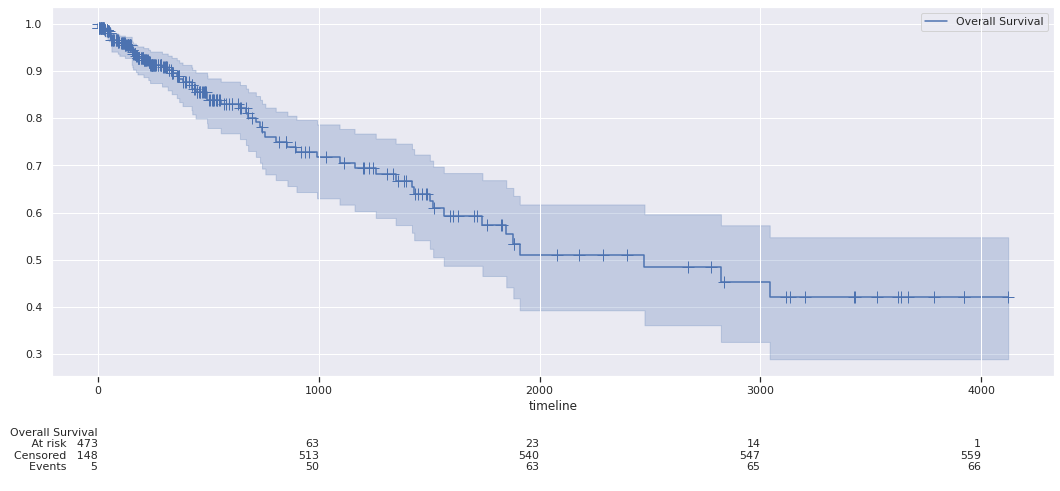

In [19]:
kmf = lifelines.KaplanMeierFitter(label="Overall Survival")
kmf.fit(durations=survival["duration"],
        event_observed=survival["observed"])
plt.figure(figsize=(15,7))
kmf.plot(show_censors=1, ci_show=1, at_risk_counts=True)

Read the cBioPortal dataset's mRNA (Seq V2), Linear CNA and Methylation (hm450) datasets.

In [20]:
cnv = pd.read_csv(os.path.join(data_directory, 'cnv.csv'), index_col=0)
gex = pd.read_csv(os.path.join(data_directory, 'gex.csv'), index_col=0)
mut = pd.read_csv(os.path.join(data_directory, 'mut.csv'), index_col=0)


cnv.shape[0], gex.shape[0], mut.shape[0]

(100, 1000, 200)

Remove any columns with a mode with more than 20% frequency

Check the maximum RNAseq count value in the dataset.

In [21]:
gex.max().max()

123568.560354

In [22]:
gex_tcga = maui_scale(gex.loc[:,gex.columns.str.contains('TCGA')])
gex_ccle = maui_scale(gex.loc[:,~gex.columns.str.contains('TCGA')])

gex = pd.concat([gex_tcga, gex_ccle], axis=1)
gex = maui_scale(gex)
gex.head()

,TCGA-DM-A1D0,TCGA-4T-AA8H,TCGA-G4-6322,TCGA-AA-A02E,TCGA-CA-5797,TCGA-G4-6317,TCGA-DM-A28C,TCGA-A6-2679,TCGA-AG-3732,TCGA-A6-2685,...,SNU1033_LARGE_INTESTINE,SNU175_LARGE_INTESTINE,SNU503_LARGE_INTESTINE,SW1116_LARGE_INTESTINE,HCC56_LARGE_INTESTINE,SW403_LARGE_INTESTINE,SW837_LARGE_INTESTINE,NCIH716_LARGE_INTESTINE,HT55_LARGE_INTESTINE,RKO_LARGE_INTESTINE
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000202198,-0.089120,-0.088563,-0.088906,-0.089667,-0.088973,-0.083947,-0.089080,-0.088551,-0.089372,-0.087775,...,-0.533138,2.542210,-0.787012,-0.609028,-0.330970,0.156823,0.344240,0.053214,0.763240,1.470719
ENSG00000211895,-0.523424,-0.202332,0.570615,-0.413167,-0.397846,-0.507563,-0.478897,12.480840,0.453555,0.285514,...,-0.491682,-0.512073,-0.376185,1.310930,-0.512073,-0.117894,-0.380050,-0.487817,-0.351135,-0.512073
ENSG00000034510,-0.033693,-0.404153,-0.453233,-0.099766,-0.244176,0.139135,-0.637896,1.407156,-1.066801,0.485294,...,-0.258449,-0.229124,-0.663397,-0.916127,0.670186,-0.638025,-1.157067,-0.657820,0.137436,-0.475331
ENSG00000087086,8.178617,-1.318908,-0.841834,-0.396125,0.277463,-0.438901,-0.522082,-0.993424,-1.322327,0.556441,...,-0.653667,-1.081281,4.123571,-0.800612,-0.409376,-0.445570,0.136440,0.135698,1.448641,2.778090
ENSG00000102837,-0.511785,-0.490640,-0.159594,-0.284401,-0.433786,-0.518334,2.243403,-0.400271,-0.453776,-0.463837,...,-0.158675,-0.161104,-0.161094,-0.161145,7.250145,-0.148832,-0.161213,-0.161194,-0.159373,-0.161196


In [23]:
gex.max().max()

22.32889197258275

Get the datasets that will be used as features and apply (log2 1+x) to the count-based datasets:

In [24]:
clinical_patients = set(survival.index)
gex_patients = set(gex.T.index)
cnv_patients = set(cnv.T.index)
mut_patients = set(mut.T.index)

all_sets = [clinical_patients, gex_patients, cnv_patients, mut_patients]
all_patients = functools.reduce(lambda x, y: x|y, all_sets, set())
patients_on_all_datasets = functools.reduce(lambda x, y: x&y, all_sets, all_patients)

In [25]:
df_clin = survival.loc[patients_on_all_datasets]
df_gex = gex.T.loc[patients_on_all_datasets]
df_cnv = cnv.T.loc[patients_on_all_datasets]
df_mut = mut.T.loc[patients_on_all_datasets]
feature_dfs = [df_gex, df_cnv, df_mut]

In [26]:
set(df_cnv.columns) & set(df_mut.columns)

{'PTPRT'}

In [27]:
df_cnv.columns = map(lambda x: x+"_cnv", df_cnv)

In [28]:
set(df_cnv.columns) & set(df_mut.columns)

set()

Get the input dataset:

In [29]:
df_ae = functools.reduce(lambda x,y: x.join(y), feature_dfs[1:], feature_dfs[0])
X_ae = scale(df_ae)
X_ae = df_ae.values

Plot a reduced dimensionality view of the dataset:

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


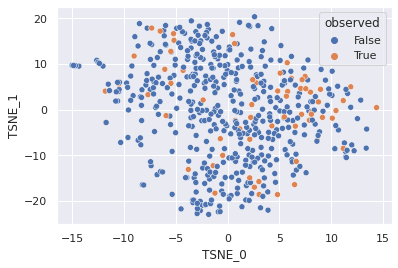

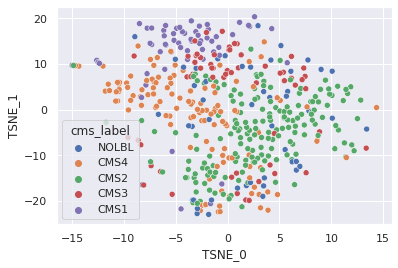

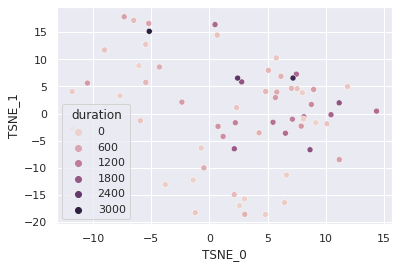

,TSNE_0,TSNE_1,duration,observed,gender,age,stage,cms_label
TCGA-G4-6321,-3.046196,9.026087,572,False,0,60.057534,3.0,NOLBL
TCGA-AZ-5403,8.643721,-6.680839,1910,True,1,43.789041,2.0,CMS4
TCGA-AA-3989,-3.749509,-11.285962,0,False,1,84.142466,4.0,CMS2
TCGA-A6-5657,-6.284740,5.696818,367,False,1,65.534247,3.0,NaN
TCGA-4N-A93T,7.717989,6.482136,8,False,1,67.186301,3.0,NaN
...,...,...,...,...,...,...,...,...
TCGA-G4-6311,-1.602500,-0.983394,1112,False,1,80.265753,3.0,CMS4
TCGA-G4-6314,-9.569227,-0.093065,1031,False,0,76.597260,4.0,CMS4
TCGA-CM-5863,-0.743627,9.723861,304,False,0,60.621918,3.0,CMS4
TCGA-AA-3867,-0.410968,-11.546717,0,False,1,74.049315,4.0,CMS4


In [30]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(X_ae), index=df_ae.index, columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin).join(subtypes[["cms_label"]], how="left")
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="observed")
plt.show()
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="cms_label")
plt.show()
sns.scatterplot(data=df_plot[df_plot["observed"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="duration")
plt.show()
df_plot

## Integrating the Data With an Autoencoder

Get the column sizes for each type of data to build a differential loss for each column:

In [31]:
column_sizes = functools.reduce(lambda x,y: x+[x[-1]+y], [len(df.columns) for df in feature_dfs], [0])
column_sizes

[0, 1000, 1100, 1300]

In [32]:
bias_eps = 1e-6
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(bias_eps)

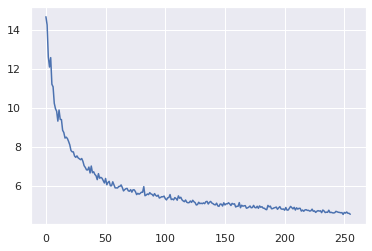

In [33]:
d_in = X_ae.shape[-1]

ae = CoxAutoencoder(
        input_dim = d_in,
        hidden_dims = [512],
        encoding_dim = 128,
        cox_hidden_dims = [],#[256]
        nonlinearity = F.relu,#torch.tanh,
        final_nonlinearity = lambda x:x,#torch.tanh,
        dropout_rate = 0.3,
        bias = True)
ae.apply(init_weights)

parameter_normalizations = [(1e-3, 1)]
activation_normalizations = [(1e-4, 2)]
average_norms = True
l2_weight_decay = 0#1e-4
noise_std = 0.2

opt = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay = l2_weight_decay)

tX_ae_clean = torch.tensor(X_ae, dtype=torch.float32)
tT = torch.tensor(df_clin["duration"], dtype=torch.float32)
tE = torch.tensor(df_clin["observed"])

epochs = 256
losses = []
for e in range(epochs):
    act_norms = 0
    act_norms_count = 0
    param_norms = 0
    param_norms_count = 0
    
    tX_ae = tX_ae_clean + torch.normal(torch.zeros_like(tX_ae_clean), noise_std)
    
    if activation_normalizations is not None and len(activation_normalizations) > 0:
        activations = ae.layer_activations(tX_ae)
        y = activations[-1]
        for norm_weight, norm_type in activation_normalizations:
            act_norms += norm_weight * sum((torch.norm(acts, norm_type) for acts in activations[:-1]))/len(activations[:-1]) # Last layer isn't included here
            act_norms_count += 1
        act_norms /= act_norms_count if average_norms else 1
    else:
        y = ae(tX_ae)
    acc = 0
    reconstruction_losses = [
        F.mse_loss(y[...,s:t], tX_ae[...,s:t])
        #F.binary_cross_entropy_with_logits(y[...,s:t], tX_ae[...,s:t])
            for s,t in zip(column_sizes[:-1], column_sizes[1:])
    ]
    coxloss = cox_ph_loss(ae.cox(tX_ae), tT, tE)
    
    for norm_weight, norm_type in parameter_normalizations:
        param_norms += norm_weight * sum((torch.norm(params, norm_type) for params in ae.parameters()))/len(list(ae.parameters()))
        param_norms_count += 1
    param_norms /= param_norms_count if average_norms else 1
        
    loss = sum(reconstruction_losses) + coxloss + param_norms + act_norms
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.detach().numpy().item())
    print("{} {}".format(e, losses[-1]), end='\x1b[1K\r')
sns.lineplot(x=list(range(len(losses))), y=losses)

ae.eval()
integrated_values = ae.encode(tX_ae).detach().numpy()

Visualise the embeddings in a lower-dimensionality projection:

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


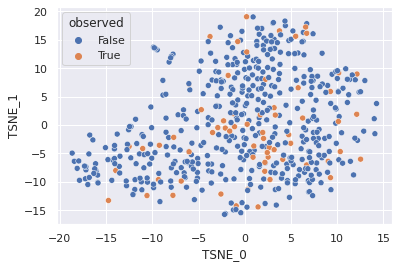

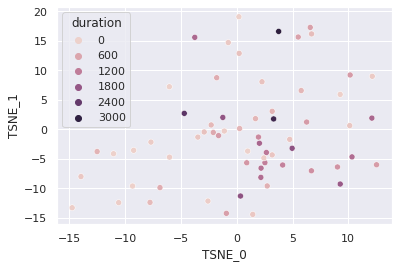

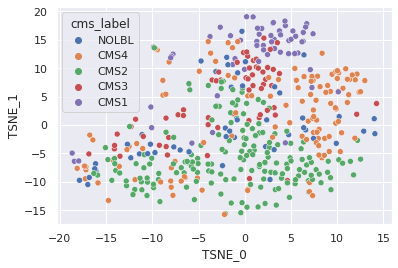

,TSNE_0,TSNE_1,duration,observed,gender,age,stage,cms_label
TCGA-G4-6321,-3.126588,9.423526,572,False,0,60.057534,3.0,NOLBL
TCGA-AZ-5403,0.335414,-11.293126,1910,True,1,43.789041,2.0,CMS4
TCGA-AA-3989,-9.180059,-13.476514,0,False,1,84.142466,4.0,CMS2
TCGA-A6-5657,6.381562,7.386992,367,False,1,65.534247,3.0,NaN
TCGA-4N-A93T,3.736429,1.705563,8,False,1,67.186301,3.0,NaN
...,...,...,...,...,...,...,...,...
TCGA-G4-6311,6.684748,-2.545912,1112,False,1,80.265753,3.0,CMS4
TCGA-G4-6314,7.713308,4.367593,1031,False,0,76.597260,4.0,CMS4
TCGA-CM-5863,2.590562,8.369735,304,False,0,60.621918,3.0,CMS4
TCGA-AA-3867,-8.015165,-9.850081,0,False,1,74.049315,4.0,CMS4


In [34]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(X_ae), index=df_ae.index, columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin).join(subtypes[["cms_label"]], how="left")
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="observed")
plt.show()
sns.scatterplot(data=df_plot[df_plot["observed"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="duration")
plt.show()
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="cms_label")
plt.show()
df_plot

### Find the Significant Factors  

In [35]:
# Set the threshold for significance
significance_threshold = 0.05

significant_factors_list = []
logRank_Pvalues_list = []

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # logRank_Pvalues is a vector that will store the log-rank p-values of each 
    # univariate Cox-PH models built
    logRank_Pvalues = list()
    # significant_factors is a vector that will store every factor for which a 
    # significant Cox-PH model was built (log-rank P < 0.05)
    significant_factor_indexes = list()
    # Iterate over all factors/features of the actual dataframe
    for i in range(integrated_values.shape[1]):
        # Create a df with 3 columns, one for factor, one for OS_MONTHS
        # and one for OS_STATUS
        factor_df = pd.DataFrame(
            {
                "duration": df_clin["duration"].values,
                "observed": df_clin["observed"].values,
                "Factor_{}".format(i): integrated_values[:,i]
            }
        )
        # Build univariate COX-PH models
        cox_ph = lifelines.fitters.coxph_fitter.CoxPHFitter().fit(factor_df, "duration", "observed")
        #log_rank_p_value = cox_ph.log_likelihood_ratio_test().p_value #summary["-log2(p)"][0]
        log_rank_p_value = cox_ph.summary["p"].mean()
        if (log_rank_p_value<significance_threshold):
            significant_factor_indexes.append(i)
            logRank_Pvalues.append(log_rank_p_value)

    print("")
    print(significant_factor_indexes)
    print(logRank_Pvalues)


[0, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 43, 44, 46, 47, 48, 49, 50, 52, 53, 56, 57, 59, 60, 61, 64, 65, 67, 68, 69, 71, 74, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 108, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
[1.1003784867304186e-16, 5.106668168847165e-10, 0.007863908667338498, 0.0010948925034112026, 7.563610842169683e-09, 0.008224464923091921, 1.6716917336404822e-10, 1.2936350197917705e-06, 5.700198465904101e-07, 0.0003526776505904299, 1.407239816218086e-17, 2.6989587417129574e-20, 2.479563076036695e-07, 6.078951842002144e-10, 0.02620976528791566, 8.310091466426474e-07, 0.0019091381948221364, 0.00046375251104604755, 8.610403984897364e-15, 3.8881561347162275e-34, 5.784501697175224e-12, 1.8891642164832223e-15, 6.443007960297699e-05, 2.4102097170531333e-05, 1.9911587737037586e-12, 3.3473894052587

In [36]:
print(
    *[
        "[{idx}]/{pval:.4f}".format(
            idx=idx,
            pval=pval
        ) for idx, pval in
        zip(
            significant_factor_indexes,
            logRank_Pvalues
        )
    ],
    sep=", "
)

[0]/0.0000, [5]/0.0000, [7]/0.0079, [8]/0.0011, [9]/0.0000, [10]/0.0082, [11]/0.0000, [12]/0.0000, [13]/0.0000, [14]/0.0004, [15]/0.0000, [17]/0.0000, [19]/0.0000, [20]/0.0000, [21]/0.0262, [24]/0.0000, [25]/0.0019, [26]/0.0005, [27]/0.0000, [28]/0.0000, [29]/0.0000, [30]/0.0000, [31]/0.0001, [32]/0.0000, [33]/0.0000, [34]/0.0000, [35]/0.0073, [36]/0.0000, [38]/0.0005, [40]/0.0000, [43]/0.0235, [44]/0.0000, [46]/0.0000, [47]/0.0000, [48]/0.0000, [49]/0.0000, [50]/0.0006, [52]/0.0000, [53]/0.0000, [56]/0.0000, [57]/0.0000, [59]/0.0000, [60]/0.0000, [61]/0.0035, [64]/0.0000, [65]/0.0394, [67]/0.0000, [68]/0.0000, [69]/0.0005, [71]/0.0021, [74]/0.0000, [76]/0.0005, [77]/0.0000, [79]/0.0000, [80]/0.0000, [81]/0.0000, [82]/0.0000, [83]/0.0000, [84]/0.0000, [85]/0.0000, [86]/0.0000, [87]/0.0490, [88]/0.0000, [89]/0.0000, [90]/0.0016, [91]/0.0003, [92]/0.0000, [93]/0.0003, [94]/0.0075, [96]/0.0000, [97]/0.0005, [98]/0.0000, [99]/0.0000, [100]/0.0000, [101]/0.0004, [103]/0.0177, [104]/0.0039, 

In [37]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # Create a df with 3 columns, one for factor, one for OS_MONTHS
    # and one for OS_STATUS
    factor_df = pd.DataFrame(
        {
            "duration": df_clin["duration"].values,
            "observed": df_clin["observed"].values,
            **{
                "Factor_{}".format(i): integrated_values[:,i]
                for i in significant_factor_indexes
            }
        }
    )
    # Build a multivariate COX-PH model for all the factors
    cox_ph = lifelines.fitters.coxph_fitter.CoxPHFitter().fit(factor_df, "duration", "observed")
    #log_rank_p_value = cox_ph.log_likelihood_ratio_test().p_value #summary["-log2(p)"][0]
    log_rank_p_value = cox_ph.summary["p"].mean()

    print(log_rank_p_value)

0.7182790562796311


In [38]:
# Set the threshold for significance
significance_threshold = 0.05

combinations_significant_factors_list = []
combinations_logRank_Pvalues_list = []

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # logRank_Pvalues is a vector that will store the log-rank p-values of each 
    # univariate Cox-PH models built
    combinations_logRank_Pvalues = [p for p in logRank_Pvalues]
    # significant_factors is a vector that will store every factor for which a 
    # significant Cox-PH model was built (log-rank P < 0.05)
    combinations_significant_factor_indexes = [[i] for i in significant_factor_indexes]
    number_of_significant_factors = len(significant_factor_indexes)
    minimum_logging_interval = 100
    last_log = 0
    try:
        with time_limit(30):
            # Iterate over all factors/features of the actual dataframe
            for k in range(2, number_of_significant_factors+1):
                for factor_indexes in itertools.combinations(significant_factor_indexes, k):
                    # Create a df with 3 columns, one for factor, one for OS_MONTHS
                    # and one for OS_STATUS
                    factor_df = pd.DataFrame(
                        {
                            "duration": df_clin["duration"].values,
                            "observed": df_clin["observed"].values,
                            **{
                                "Factor_{}".format(i): integrated_values[:,i]
                                for i in factor_indexes
                            }

                        }
                    )
                    # Build univariate COX-PH models
                    cox_ph = lifelines.fitters.coxph_fitter.CoxPHFitter().fit(factor_df, "duration", "observed")
                    #log_rank_p_value = cox_ph.log_likelihood_ratio_test().p_value #summary["-log2(p)"][0]
                    log_rank_p_value = cox_ph.summary["p"].mean()
                    if (log_rank_p_value<significance_threshold):
                        combinations_significant_factor_indexes.append(factor_indexes)
                        combinations_logRank_Pvalues.append(log_rank_p_value)
                    if (log_rank_p_value<significance_threshold or last_log > minimum_logging_interval):
                        last_log = 0
                        print(log_rank_p_value, factor_indexes)
                    else:
                        last_log
    except (KeyboardInterrupt, TimeoutException):
        pass
    print("")
    print(combinations_significant_factor_indexes)
    print(combinations_logRank_Pvalues)

6.673473178403844e-13 (0, 5)
0.0026726206298493733 (0, 7)
0.0005539136855942133 (0, 8)
6.7407652371722525e-06 (0, 9)
2.855170803680009e-07 (0, 10)
0.007882267736246127 (0, 11)
2.2568307273077263e-11 (0, 12)
8.371518108249125e-06 (0, 13)
5.087100596386106e-16 (0, 15)
3.494210022006358e-10 (0, 17)
1.583594207368653e-11 (0, 19)
8.763137650122681e-13 (0, 20)
0.0011732608763809797 (0, 24)
0.005440193599720579 (0, 25)
0.00012793846512114016 (0, 26)
2.8226969452633665e-18 (0, 27)
7.114902507960035e-08 (0, 28)
4.4590906771844284e-09 (0, 29)
1.4252743983836569e-05 (0, 30)
0.03090069702111328 (0, 31)
5.3435011668639384e-11 (0, 32)
4.5776771292199887e-07 (0, 33)
9.276601237719837e-06 (0, 34)
0.009082379523178122 (0, 35)
5.021217980947817e-08 (0, 36)
7.525993715818923e-05 (0, 38)
3.0620444334468616e-09 (0, 40)
0.04104241434618302 (0, 44)
9.505422630217878e-09 (0, 46)
1.2563014934465105e-16 (0, 47)
2.278769558823377e-11 (0, 48)
4.197315239778456e-16 (0, 49)
0.006373210325646409 (0, 50)
0.0233936583

0.0009364972475035369 (8, 34)
0.0006602266786492759 (8, 35)
2.6311193915794042e-05 (8, 36)
0.0015353814906011345 (8, 38)
0.00016941214634212545 (8, 40)
0.0024639217499008268 (8, 43)
0.006022213728438906 (8, 44)
5.510548314610985e-06 (8, 46)
0.0008107579353055706 (8, 47)
0.0016148513328994663 (8, 48)
0.02338392330053204 (8, 49)
0.004484045333890225 (8, 50)
2.1563301340084057e-05 (8, 52)
2.540564101234298e-05 (8, 53)
5.268226946667708e-07 (8, 56)
5.498106592406639e-05 (8, 57)
5.73084649728209e-09 (8, 59)
2.3392651857370023e-08 (8, 60)
1.1001625427083746e-05 (8, 61)
5.287846690641352e-06 (8, 64)
0.0010781072706503901 (8, 65)
0.005308180313711605 (8, 67)

[[0], [5], [7], [8], [9], [10], [11], [12], [13], [14], [15], [17], [19], [20], [21], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [38], [40], [43], [44], [46], [47], [48], [49], [50], [52], [53], [56], [57], [59], [60], [61], [64], [65], [67], [68], [69], [71], [74], [76], [77], [79], [80], [81], [82], [8

In [39]:
print(
    *[
        "{idx}/{pval:.4f}".format(
            idx=idx,
            pval=pval
        ) for idx, pval in
        zip(
            combinations_significant_factor_indexes,
            combinations_logRank_Pvalues
        ) if len(idx)>1
    ],
    sep=", "
)

(0, 5)/0.0000, (0, 7)/0.0027, (0, 8)/0.0006, (0, 9)/0.0000, (0, 10)/0.0000, (0, 11)/0.0079, (0, 12)/0.0000, (0, 13)/0.0000, (0, 15)/0.0000, (0, 17)/0.0000, (0, 19)/0.0000, (0, 20)/0.0000, (0, 24)/0.0012, (0, 25)/0.0054, (0, 26)/0.0001, (0, 27)/0.0000, (0, 28)/0.0000, (0, 29)/0.0000, (0, 30)/0.0000, (0, 31)/0.0309, (0, 32)/0.0000, (0, 33)/0.0000, (0, 34)/0.0000, (0, 35)/0.0091, (0, 36)/0.0000, (0, 38)/0.0001, (0, 40)/0.0000, (0, 44)/0.0410, (0, 46)/0.0000, (0, 47)/0.0000, (0, 48)/0.0000, (0, 49)/0.0000, (0, 50)/0.0064, (0, 52)/0.0234, (0, 53)/0.0000, (0, 56)/0.0000, (0, 57)/0.0000, (0, 59)/0.0000, (0, 60)/0.0000, (0, 61)/0.0000, (0, 64)/0.0198, (0, 65)/0.0000, (0, 67)/0.0000, (0, 68)/0.0000, (0, 69)/0.0002, (0, 71)/0.0000, (0, 76)/0.0000, (0, 77)/0.0011, (0, 79)/0.0000, (0, 80)/0.0000, (0, 81)/0.0000, (0, 82)/0.0000, (0, 83)/0.0000, (0, 84)/0.0000, (0, 85)/0.0000, (0, 86)/0.0000, (0, 88)/0.0000, (0, 89)/0.0000, (0, 92)/0.0326, (0, 93)/0.0000, (0, 94)/0.0000, (0, 96)/0.0000, (0, 97)/0.03

In [40]:
lowest_combination = np.argmin(combinations_logRank_Pvalues)
lowest_combination_significant_factors = combinations_significant_factor_indexes[lowest_combination]
lowest_combination_p_value = combinations_logRank_Pvalues[lowest_combination]
lowest_combination_significant_factors, lowest_combination_p_value

([28], 3.8881561347162275e-34)

Get a dataframe with only the significant factors:

In [41]:
significant_factors = integrated_values[:,significant_factor_indexes]
significant_factors

array([[-1.1617706e+00,  3.8261202e-01, -1.3522954e+00, ...,
         1.2586743e-01,  2.9256563e+00,  5.3745806e-01],
       [ 7.3313171e-01,  2.1960988e+00,  4.6390548e-01, ...,
         7.6271999e-01,  7.9265893e-02,  9.2958391e-01],
       [-1.9344605e+00,  1.6991460e+00, -1.3378944e+00, ...,
         2.6212041e+00,  3.1043010e+00,  7.4887288e-01],
       ...,
       [-9.2983663e-01,  2.2718550e-01, -7.5006163e-01, ...,
        -1.9983676e-01, -4.4441223e-04,  1.5807939e-01],
       [-4.9940526e-01,  1.7314558e+00, -1.2569377e-01, ...,
        -2.7069539e-01,  7.0577091e-01,  1.3711262e+00],
       [-3.1053579e-01,  5.8042735e-01,  1.3100581e+00, ...,
         2.0651151e-01, -2.4089837e-01,  1.0805130e+00]], dtype=float32)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


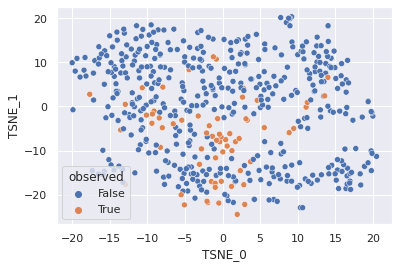

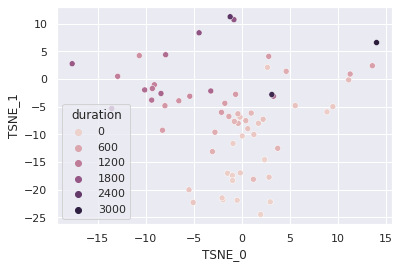

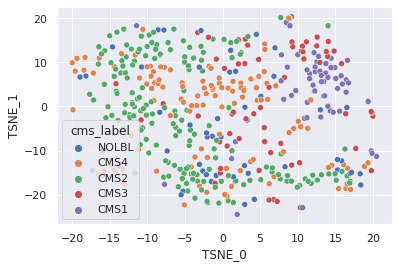

,TSNE_0,TSNE_1,duration,observed,gender,age,stage,cms_label
TCGA-G4-6321,4.494912,16.347452,572,False,0,60.057534,3.0,NOLBL
TCGA-AZ-5403,-13.538125,-5.326551,1910,True,1,43.789041,2.0,CMS4
TCGA-AA-3989,1.430237,-21.757915,0,False,1,84.142466,4.0,CMS2
TCGA-A6-5657,4.967449,5.050333,367,False,1,65.534247,3.0,NaN
TCGA-4N-A93T,0.194298,-2.537160,8,False,1,67.186301,3.0,NaN
...,...,...,...,...,...,...,...,...
TCGA-G4-6311,-10.024383,8.988712,1112,False,1,80.265753,3.0,CMS4
TCGA-G4-6314,-6.913805,8.299363,1031,False,0,76.597260,4.0,CMS4
TCGA-CM-5863,5.140531,1.456584,304,False,0,60.621918,3.0,CMS4
TCGA-AA-3867,0.305542,-19.955341,0,False,1,74.049315,4.0,CMS4


In [42]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(significant_factors), index=df_ae.index, columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin).join(subtypes[["cms_label"]], how="left")
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="observed")
plt.show()
sns.scatterplot(data=df_plot[df_plot["observed"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="duration")
plt.show()
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="cms_label")
plt.show()
df_plot

In [43]:
comb_significant_factors = integrated_values[:,lowest_combination_significant_factors]
comb_significant_factors

array([[-2.64789867e+00],
       [-1.93591148e-01],
       [ 1.07467031e+00],
       [-1.41876769e+00],
       [-4.43750530e-01],
       [-1.23811197e+00],
       [-1.47365642e+00],
       [ 1.46460176e-01],
       [ 3.76457810e-01],
       [-1.38861918e+00],
       [ 1.97749004e-01],
       [-2.27017030e-01],
       [-1.89594436e+00],
       [-5.92270613e-01],
       [-6.32400870e-01],
       [-3.96219373e-01],
       [ 5.60157537e-01],
       [ 4.16489840e-01],
       [-6.31743908e-01],
       [-5.87596893e-01],
       [ 2.31715590e-01],
       [-1.09774137e+00],
       [-7.78536677e-01],
       [-7.40260184e-01],
       [-4.36042875e-01],
       [-7.79295921e-01],
       [-1.29841232e+00],
       [-1.11127460e+00],
       [ 5.02625227e-01],
       [-1.59898937e-01],
       [-1.53475404e-01],
       [-5.56210876e-01],
       [-1.57897282e+00],
       [-8.98662746e-01],
       [ 3.07793438e-01],
       [ 1.63697481e+00],
       [ 8.29193741e-02],
       [-9.45512354e-01],
       [-1.2

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


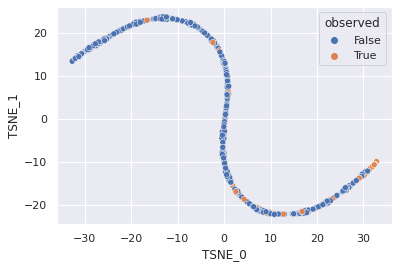

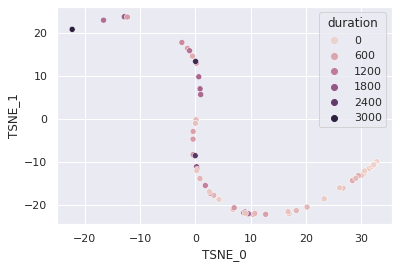

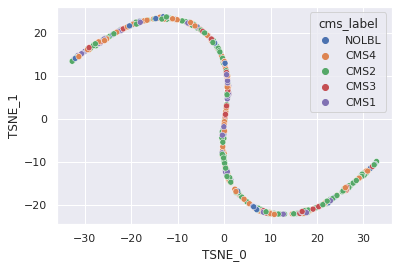

,TSNE_0,TSNE_1,duration,observed,gender,age,stage,cms_label
TCGA-G4-6321,-31.035164,14.866133,572,False,0,60.057534,3.0,NOLBL
TCGA-AZ-5403,0.221798,-11.141499,1910,True,1,43.789041,2.0,CMS4
TCGA-AA-3989,26.488630,-16.452991,0,False,1,84.142466,4.0,CMS2
TCGA-A6-5657,-18.881590,21.984543,367,False,1,65.534247,3.0,NaN
TCGA-4N-A93T,0.223626,0.671213,8,False,1,67.186301,3.0,NaN
...,...,...,...,...,...,...,...,...
TCGA-G4-6311,-6.290095,21.560734,1112,False,1,80.265753,3.0,CMS4
TCGA-G4-6314,-31.309164,14.441655,1031,False,0,76.597260,4.0,CMS4
TCGA-CM-5863,-11.120447,23.217499,304,False,0,60.621918,3.0,CMS4
TCGA-AA-3867,26.106205,-16.034111,0,False,1,74.049315,4.0,CMS4


In [44]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(comb_significant_factors), index=df_ae.index, columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin).join(subtypes[["cms_label"]], how="left")
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="observed")
plt.show()
sns.scatterplot(data=df_plot[df_plot["observed"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="duration")
plt.show()
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="cms_label")
plt.show()
df_plot

### Working Back Features from Factors

To be done, but not strictly necessary since later in the pipeline we will extract the most significant features directly using the low/high risk separation.

## Cluster Samples

In [45]:
for k in range(2,9):
    kmeans = KMeans(k)
    kmeans.fit(significant_factors)
    labels = kmeans.labels_
    silhouette = silhouette_score(factor_df, labels)
    CH_score = calinski_harabasz_score(factor_df, labels)
    print("k="+str(k))
    print("Silhouette score:", silhouette)
    print("CH score", CH_score)
    print()

k=2
Silhouette score: -0.0025542038382872856
CH score 49.03653580906148

k=3
Silhouette score: -0.12029839590008642
CH score 20.139520715858378

k=4
Silhouette score: -0.2229171809409232
CH score 13.80137357528847

k=5
Silhouette score: -0.38437704990926985
CH score 9.995002264590978

k=6
Silhouette score: -0.39005502517793583
CH score 8.353047882318645

k=7
Silhouette score: -0.4385027765720875
CH score 9.184725241210849

k=8
Silhouette score: -0.4540040014748615
CH score 8.94496972504911



Two clusters seem to be consistently better than any other number, so keep 2 clusters as the default and plot the survival curves of each, doing a logrank test to see if they are significantly different.

Try making some clusters to see how varied the clustering can be over the significant factors:

In [46]:
number_of_clusters = 32
clusters = []
logrank_ps = []
for i in range(number_of_clusters):
    kmeans = KMeans(2).fit(significant_factors)
    kmf_low, kmf_high, low_risk_samples, high_risk_samples = kmf_high_low(df_clin, kmeans.labels_)
    # Compute the log-rank test P value between the 2 survival functions
    results = lifelines.statistics.logrank_test(high_risk_samples["duration"], low_risk_samples["duration"],
                           high_risk_samples["observed"], low_risk_samples["observed"])
    clusters.append(kmeans)
    logrank_ps.append(results.p_value)
print("log-rank P values: ",logrank_ps)
print("mean +/- std: {avg} +/- {std}".format(avg=np.mean(logrank_ps), std=np.std(logrank_ps)))
n_significant = sum((p<0.05 for p in logrank_ps))
print("n_significant: {} ({:.2%})".format(n_significant, n_significant/number_of_clusters))

log-rank P values:  [2.5807435378495793e-31, 2.5807435378495793e-31, 2.703645388629936e-32, 1.1884790413509684e-33, 2.703645388629936e-32, 1.1884790413509684e-33, 2.5807435378495793e-31, 4.4055365605112265e-32, 4.4055365605112265e-32, 1.709060424867847e-32, 4.4055365605112265e-32, 5.268872942121179e-32, 1.1884790413509684e-33, 1.1884790413509684e-33, 1.594640462552421e-31, 2.5807435378495793e-31, 2.5807435378495793e-31, 1.594640462552421e-31, 6.065423358480599e-32, 4.4055365605112265e-32, 1.550417785585061e-32, 4.4055365605112265e-32, 4.4055365605112265e-32, 6.88692614327572e-32, 2.5807435378495793e-31, 1.1884790413509684e-33, 4.4055365605112265e-32, 4.4055365605112265e-32, 4.4055365605112265e-32, 2.5807435378495793e-31, 4.4055365605112265e-32, 1.1884790413509684e-33]
mean +/- std: 8.881290667563503e-32 +/- 9.638405936505741e-32
n_significant: 32 (100.00%)


Try making 16 different clusters with the integrated values to see what effect the Cox-PH model has on the survival curve.

In [47]:
number_of_clusters = 32
clusters = []
logrank_ps = []
for i in range(number_of_clusters):
    kmeans = KMeans(2).fit(integrated_values)
    kmf_low, kmf_high, low_risk_samples, high_risk_samples = kmf_high_low(df_clin, kmeans.labels_)
    # Compute the log-rank test P value between the 2 survival functions
    results = lifelines.statistics.logrank_test(high_risk_samples["duration"], low_risk_samples["duration"],
                           high_risk_samples["observed"], low_risk_samples["observed"])
    clusters.append(kmeans)
    logrank_ps.append(results.p_value)
print("log-rank P values: ",logrank_ps)
print("mean +/- std: {avg} +/- {std}".format(avg=np.mean(logrank_ps), std=np.std(logrank_ps)))
n_significant = sum((p<0.05 for p in logrank_ps))
print("n_significant: {} ({:.2%})".format(n_significant, n_significant/number_of_clusters))

log-rank P values:  [0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.42375861997686237, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.42375861997686237, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461, 0.4165623305342461]
mean +/- std: 0.4170120986244096 +/- 0.001741944322858824
n_significant: 0 (0.00%)


Now do the same, but randomly selecting features for each cluster inversely proportionally to the amount of clusters we're building

In [48]:
number_of_clusters = 32
clusters = []
logrank_ps = []
for i in range(number_of_clusters):
    kmeans = KMeans(2).fit(
        integrated_values[
            ...,
            np.random.randint(
                0,
                integrated_values.shape[-1],
                int(integrated_values.shape[-1]/(number_of_clusters*0.8))
            )
        ]
    )
    kmf_low, kmf_high, low_risk_samples, high_risk_samples = kmf_high_low(df_clin, kmeans.labels_)
    # Compute the log-rank test P value between the 2 survival functions
    results = lifelines.statistics.logrank_test(high_risk_samples["duration"], low_risk_samples["duration"],
                           high_risk_samples["observed"], low_risk_samples["observed"])
    clusters.append(kmeans)
    logrank_ps.append(results.p_value)
print("log-rank P values: ",logrank_ps)
print("mean +/- std: {avg} +/- {std}".format(avg=np.mean(logrank_ps), std=np.std(logrank_ps)))
n_significant = sum((p<0.05 for p in logrank_ps))
print("n_significant: {} ({:.2%})".format(n_significant, n_significant/number_of_clusters))

log-rank P values:  [0.8010038831898503, 3.649408949576542e-11, 4.540923804257023e-14, 0.00039716869961409196, 0.10330275019642435, 2.456300347577389e-12, 9.83056555512581e-09, 0.06117654661884397, 4.939727440678479e-13, 7.039819068162458e-05, 8.380181777987695e-09, 0.06985613129617792, 3.396770292548505e-16, 0.6399415253828755, 0.20340752608049784, 2.455412751575178e-05, 1.1153842791175303e-24, 0.3228596398743824, 2.8780134013178305e-24, 3.078228962184051e-05, 1.2251635182259173e-11, 0.013237536948745165, 0.1937862223593724, 6.018733669315268e-07, 1.2336254928261679e-14, 0.34089629134491467, 1.4492571909624054e-07, 2.7006368642406886e-05, 4.054318590610864e-23, 0.004718957737223171, 0.004622055573724805, 0.00035829748890026596]
mean +/- std: 0.08624118871342487 +/- 0.18808412575905767
n_significant: 23 (71.88%)


Make one cluster with the significant factors and plot its survival curve and reduced dimensionality projections:

log-rank P value: 1.594640462552421e-31


<AxesSubplot:xlabel='timeline'>

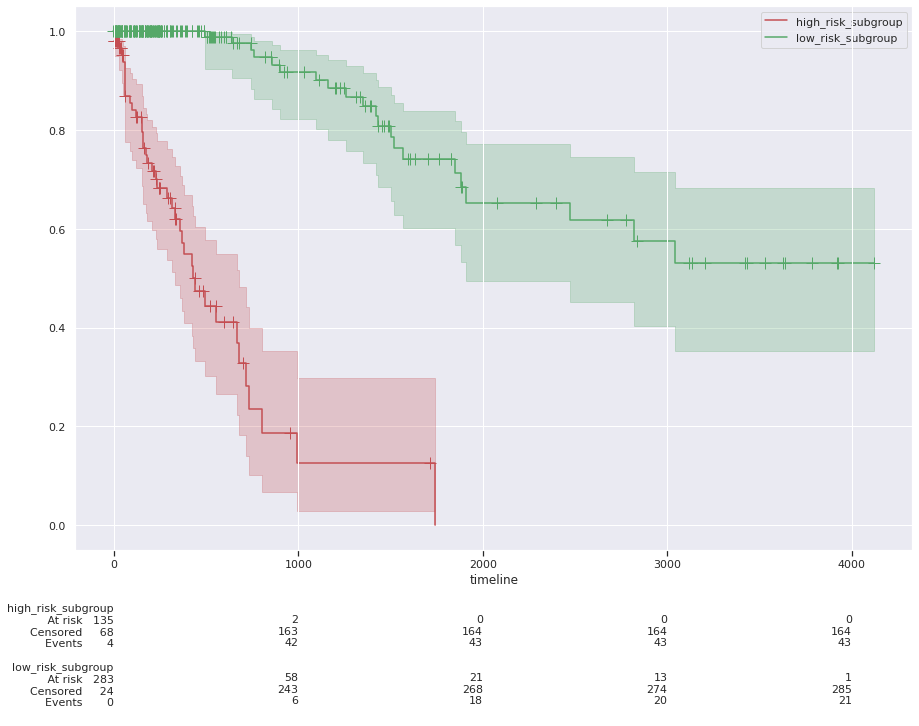

In [49]:
kmeans = KMeans(2).fit(significant_factors)
kmf_low, kmf_high, low_risk_samples, high_risk_samples = kmf_high_low(df_clin, kmeans.labels_)
# Compute the log-rank test P value between the 2 survival functions
results = lifelines.statistics.logrank_test(high_risk_samples["duration"], low_risk_samples["duration"],
                       high_risk_samples["observed"], low_risk_samples["observed"])
print("log-rank P value:",results.p_value)
plt.figure(figsize=(15,10))
ax = plt.gca()
kmf_high.plot(show_censors=1, ci_show=1, color="r", ax=ax)
kmf_low.plot(show_censors=1, ci_show=1, color="g", ax=ax)
lifelines.plotting.add_at_risk_counts(kmf_high, kmf_low, ax=ax)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


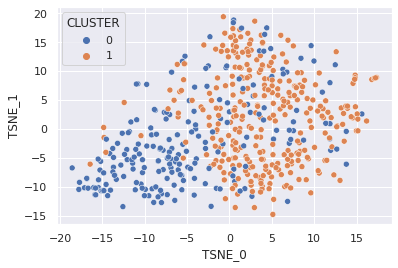

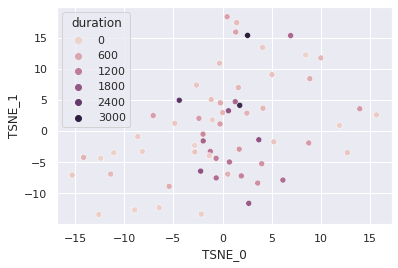

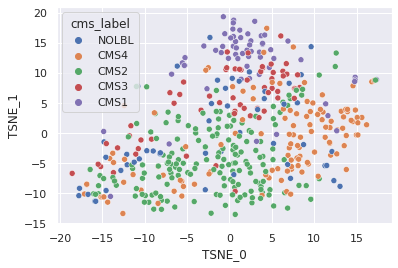

,TSNE_0,TSNE_1,duration,observed,gender,age,stage,cms_label,CLUSTER
TCGA-G4-6321,8.467345,9.732366,572,False,0,60.057534,3.0,NOLBL,1
TCGA-AZ-5403,-2.237589,-6.416971,1910,True,1,43.789041,2.0,CMS4,1
TCGA-AA-3989,-11.429023,-5.873030,0,False,1,84.142466,4.0,CMS2,0
TCGA-A6-5657,2.145027,7.027705,367,False,1,65.534247,3.0,NaN,1
TCGA-4N-A93T,2.136617,4.258462,8,False,1,67.186301,3.0,NaN,0
...,...,...,...,...,...,...,...,...,...
TCGA-G4-6311,7.289278,-4.471214,1112,False,1,80.265753,3.0,CMS4,1
TCGA-G4-6314,9.663798,0.294822,1031,False,0,76.597260,4.0,CMS4,1
TCGA-CM-5863,5.045062,8.468999,304,False,0,60.621918,3.0,CMS4,1
TCGA-AA-3867,-6.532764,-9.655638,0,False,1,74.049315,4.0,CMS4,0


In [50]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(X_ae), index=df_ae.index, columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin).join(subtypes[["cms_label"]], how="left")
df_plot["CLUSTER"] = kmeans.labels_
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="CLUSTER")
plt.show()
sns.scatterplot(data=df_plot[df_plot["observed"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="duration")
plt.show()
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="cms_label")
plt.show()
df_plot

Make one cluster with the integrated values and plot its survival curve and reduced dimensionality projections:

log-rank P value: 0.4165623305342461


<AxesSubplot:xlabel='timeline'>

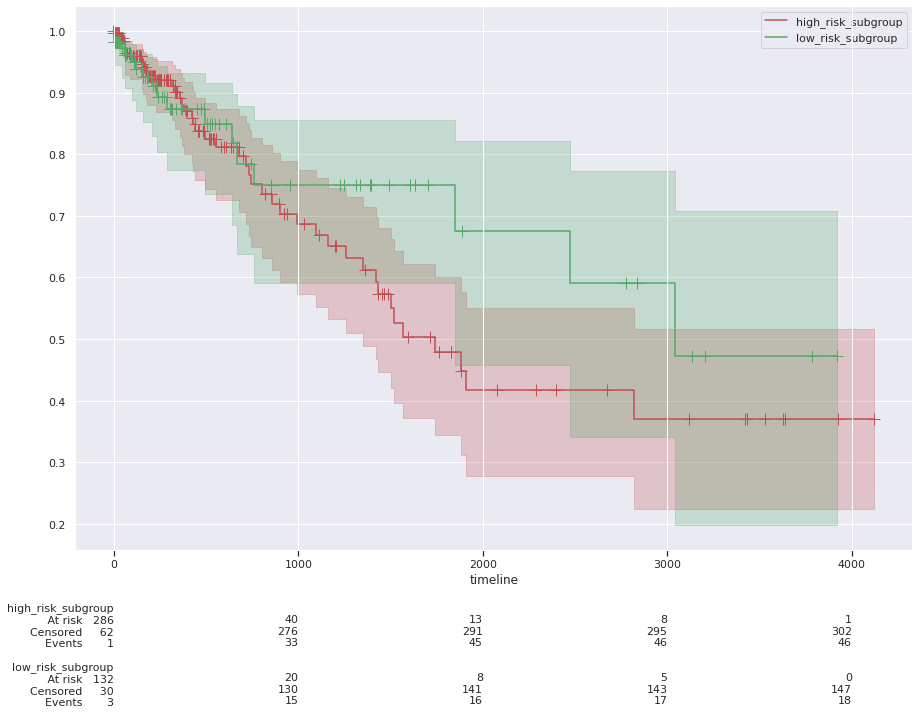

In [51]:
kmeans = KMeans(2).fit(integrated_values)
kmf_low, kmf_high, low_risk_samples, high_risk_samples = kmf_high_low(df_clin, kmeans.labels_)
# Compute the log-rank test P value between the 2 survival functions
results = lifelines.statistics.logrank_test(high_risk_samples["duration"], low_risk_samples["duration"],
                       high_risk_samples["observed"], low_risk_samples["observed"])
print("log-rank P value:",results.p_value)
plt.figure(figsize=(15,10))
ax = plt.gca()
kmf_high.plot(show_censors=1, ci_show=1, color="r", ax=ax)
kmf_low.plot(show_censors=1, ci_show=1, color="g", ax=ax)
lifelines.plotting.add_at_risk_counts(kmf_high, kmf_low, ax=ax)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


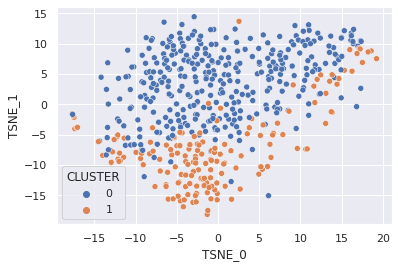

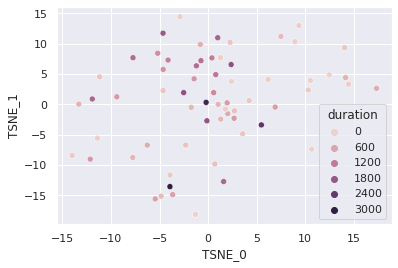

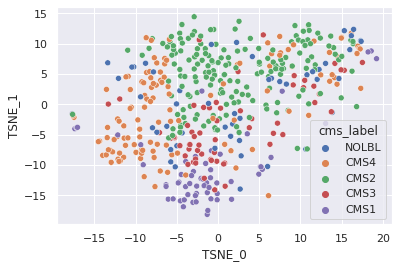

,TSNE_0,TSNE_1,duration,observed,gender,age,stage,cms_label,CLUSTER
TCGA-G4-6321,-4.987076,-6.845508,572,False,0,60.057534,3.0,NOLBL,1
TCGA-AZ-5403,2.370980,6.557190,1910,True,1,43.789041,2.0,CMS4,0
TCGA-AA-3989,11.805037,6.504966,0,False,1,84.142466,4.0,CMS2,0
TCGA-A6-5657,-8.291078,-8.164989,367,False,1,65.534247,3.0,NaN,1
TCGA-4N-A93T,-14.182367,4.461713,8,False,1,67.186301,3.0,NaN,0
...,...,...,...,...,...,...,...,...,...
TCGA-G4-6311,-6.806178,3.623550,1112,False,1,80.265753,3.0,CMS4,0
TCGA-G4-6314,-9.721905,-2.575197,1031,False,0,76.597260,4.0,CMS4,0
TCGA-CM-5863,-4.911201,-8.052576,304,False,0,60.621918,3.0,CMS4,1
TCGA-AA-3867,8.532411,9.029535,0,False,1,74.049315,4.0,CMS4,0


In [52]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(X_ae), index=df_ae.index, columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin).join(subtypes[["cms_label"]], how="left")
df_plot["CLUSTER"] = kmeans.labels_
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="CLUSTER")
plt.show()
sns.scatterplot(data=df_plot[df_plot["observed"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="duration")
plt.show()
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="cms_label")
plt.show()
df_plot

Now do the same but with the factors that when combined have the lowest p value:

In [53]:
number_of_clusters = 32
clusters = []
logrank_ps = []
for i in range(number_of_clusters):
    kmeans = KMeans(2).fit(comb_significant_factors)
    kmf_low, kmf_high, low_risk_samples, high_risk_samples = kmf_high_low(df_clin, kmeans.labels_)
    # Compute the log-rank test P value between the 2 survival functions
    results = lifelines.statistics.logrank_test(high_risk_samples["duration"], low_risk_samples["duration"],
                           high_risk_samples["observed"], low_risk_samples["observed"])
    clusters.append(kmeans)
    logrank_ps.append(results.p_value)
print("log-rank P values: ",logrank_ps)
print("mean +/- std: {avg} +/- {std}".format(avg=np.mean(logrank_ps), std=np.std(logrank_ps)))
n_significant = sum((p<0.05 for p in logrank_ps))
print("n_significant: {} ({:.2%})".format(n_significant, n_significant/number_of_clusters))

log-rank P values:  [2.834351580125536e-22, 4.5806855807299284e-23, 4.5806855807299284e-23, 4.5806855807299284e-23, 2.834351580125536e-22, 2.834351580125536e-22, 4.5806855807299284e-23, 4.5806855807299284e-23, 4.5806855807299284e-23, 2.834351580125536e-22, 4.5806855807299284e-23, 4.5806855807299284e-23, 4.5806855807299284e-23, 2.834351580125536e-22, 4.5806855807299284e-23, 4.5806855807299284e-23, 4.5806855807299284e-23, 4.5806855807299284e-23, 4.5806855807299284e-23, 2.834351580125536e-22, 4.5806855807299284e-23, 2.834351580125536e-22, 2.834351580125536e-22, 4.5806855807299284e-23, 4.5806855807299284e-23, 4.5806855807299284e-23, 2.834351580125536e-22, 4.5806855807299284e-23, 2.834351580125536e-22, 2.834351580125536e-22, 4.5806855807299284e-23, 4.5806855807299284e-23]
mean +/- std: 1.2749158469035547e-22 +/- 1.1286367222396562e-22
n_significant: 32 (100.00%)


Make one cluster with the best combination of significant factors and plot its survival curve and reduced dimensionality projections:

log-rank P value: 4.5806855807299284e-23


<AxesSubplot:xlabel='timeline'>

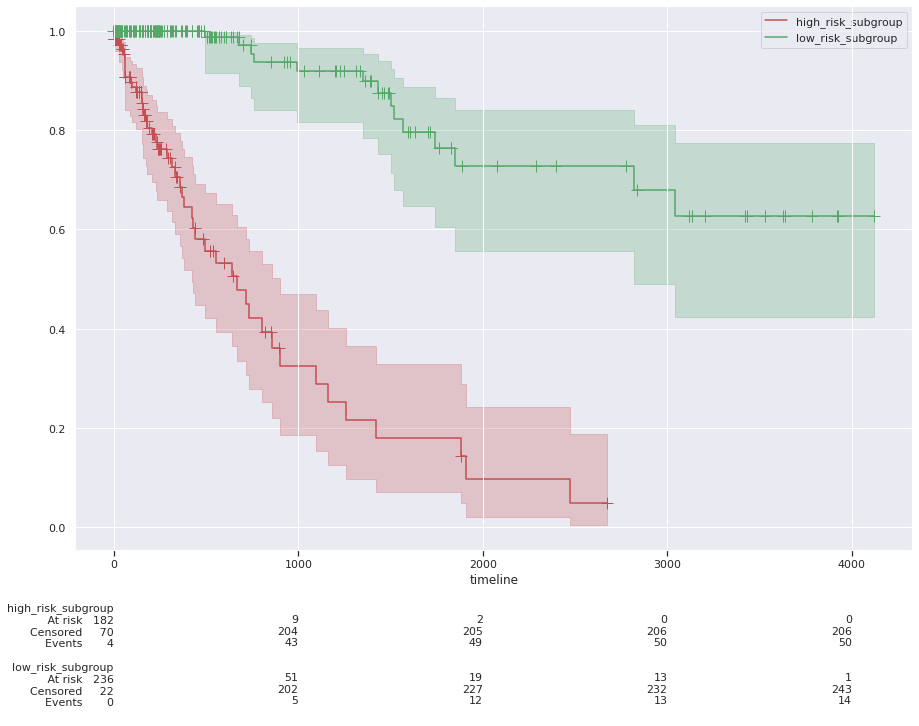

In [54]:
kmeans = KMeans(2).fit(comb_significant_factors)
kmf_low, kmf_high, low_risk_samples, high_risk_samples = kmf_high_low(df_clin, kmeans.labels_)
# Compute the log-rank test P value between the 2 survival functions
results = lifelines.statistics.logrank_test(high_risk_samples["duration"], low_risk_samples["duration"],
                       high_risk_samples["observed"], low_risk_samples["observed"])
print("log-rank P value:",results.p_value)
plt.figure(figsize=(15,10))
ax = plt.gca()
kmf_high.plot(show_censors=1, ci_show=1, color="r", ax=ax)
kmf_low.plot(show_censors=1, ci_show=1, color="g", ax=ax)
lifelines.plotting.add_at_risk_counts(kmf_high, kmf_low, ax=ax)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


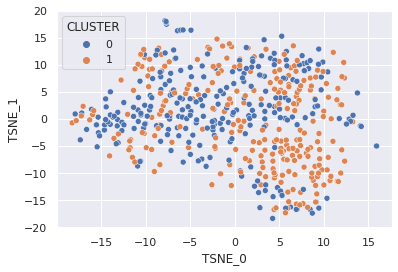

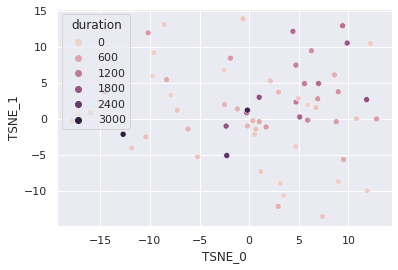

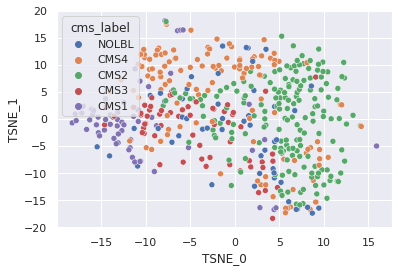

,TSNE_0,TSNE_1,duration,observed,gender,age,stage,cms_label,CLUSTER
TCGA-G4-6321,-9.517908,4.365630,572,False,0,60.057534,3.0,NOLBL,0
TCGA-AZ-5403,11.839615,2.680749,1910,True,1,43.789041,2.0,CMS4,1
TCGA-AA-3989,5.339037,-10.373078,0,False,1,84.142466,4.0,CMS2,1
TCGA-A6-5657,-6.462816,-1.595848,367,False,1,65.534247,3.0,NaN,0
TCGA-4N-A93T,0.188625,1.681661,8,False,1,67.186301,3.0,NaN,0
...,...,...,...,...,...,...,...,...,...
TCGA-G4-6311,1.289399,9.362716,1112,False,1,80.265753,3.0,CMS4,0
TCGA-G4-6314,-6.080581,8.994227,1031,False,0,76.597260,4.0,CMS4,0
TCGA-CM-5863,-7.611837,0.638497,304,False,0,60.621918,3.0,CMS4,0
TCGA-AA-3867,9.524818,-7.334766,0,False,1,74.049315,4.0,CMS4,1


In [55]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(X_ae), index=df_ae.index, columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin).join(subtypes[["cms_label"]], how="left")
df_plot["CLUSTER"] = kmeans.labels_
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="CLUSTER")
plt.show()
sns.scatterplot(data=df_plot[df_plot["observed"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="duration")
plt.show()
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="cms_label")
plt.show()
df_plot

Assign samples randomly just to see how it looks:

log-rank P value: 0.7376776951840764


<AxesSubplot:xlabel='timeline'>

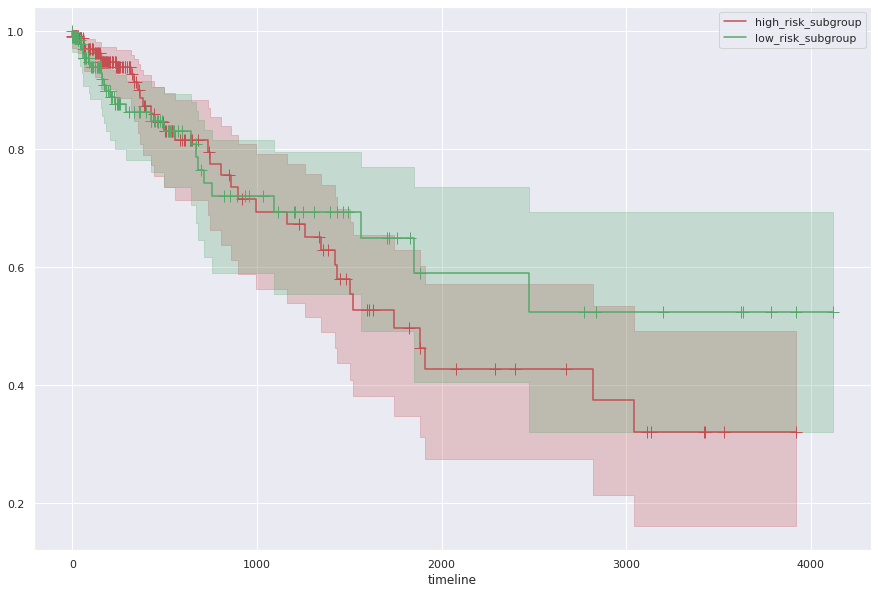

In [56]:
target_features = df_clin.copy()
kmf_low, kmf_high, low_risk_samples, high_risk_samples = kmf_high_low(df_clin, np.random.choice([0,1], size=df_clin.shape[0]))
# Compute the log-rank test P value between the 2 survival functions
results = lifelines.statistics.logrank_test(high_risk_samples["duration"], low_risk_samples["duration"],
                       high_risk_samples["observed"], low_risk_samples["observed"])
print("log-rank P value:",results.p_value)
plt.figure(figsize=(15,10))
ax = plt.gca()
kmf_high.plot(show_censors=1, ci_show=1, color="r", ax=ax)
kmf_low.plot(show_censors=1, ci_show=1, color="g", ax=ax)
#lifelines.plotting.add_at_risk_counts(kmf_high, kmf_low, ax=ax)

Set the clusters from the kmeans algorithm as the dataset labels for training in the next parts of the pipeline:

In [57]:
target_features = df_clin.copy()
target_features["Risk_subgroup"] = kmeans.labels_
target_features

,duration,observed,gender,age,stage,Risk_subgroup
bcr_patient_barcode,,,,,,
TCGA-G4-6321,572,False,0,60.057534,3.0,0
TCGA-AZ-5403,1910,True,1,43.789041,2.0,1
TCGA-AA-3989,0,False,1,84.142466,4.0,1
TCGA-A6-5657,367,False,1,65.534247,3.0,0
TCGA-4N-A93T,8,False,1,67.186301,3.0,0
...,...,...,...,...,...,...
TCGA-G4-6311,1112,False,1,80.265753,3.0,0
TCGA-G4-6314,1031,False,0,76.597260,4.0,0
TCGA-CM-5863,304,False,0,60.621918,3.0,0


## Feature Selection

## Training a Model for prediction survival

## External dataset validation

## Discussion

## Next steps

Voting scheme
FPKM/TPM
Bioconductor workshops